In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import sys
sys.path.append('src/')


import numpy as np
import matplotlib.pyplot as plt


from loguru import logger

from WADParser import open_wad_file
from WADViewer import save_music, WadViewer
from WADPlayer import MIDIPlayer

In [40]:
w = open_wad_file('WADs/HERETIC.WAD')

2025-03-28 17:33:28.691 | INFO     | WADParser:__init__:41 - Found a HERETIC IWAD.
2025-03-28 17:33:28.693 | INFO     | WADParser:_get_palette:116 - Palette extracted.
2025-03-28 17:33:28.696 | INFO     | WADParser:_parse_levels:156 - Found 48 level(s) in this WAD.
2025-03-28 17:33:28.696 | INFO     | WADParser:_parse_things:128 - HERETIC THINGS loaded.
2025-03-28 17:33:28.896 | INFO     | WADParser:_parse_by_markers:186 - 66 FLATS found in this WAD.
2025-03-28 17:33:28.901 | INFO     | WADParser:_parse_by_markers:186 - 1490 SPRITES found in this WAD.
2025-03-28 17:33:28.957 | INFO     | WADParser:_gather_textures:352 - Found 100 textures in 2 texture lumps.
2025-03-28 17:33:28.958 | INFO     | WADParser:_gather_musics:359 - No music found in this IWAD.


In [41]:
viewer = WadViewer(w)


NotImplementedError: Flats can be only of 64*64 size. For the moment.

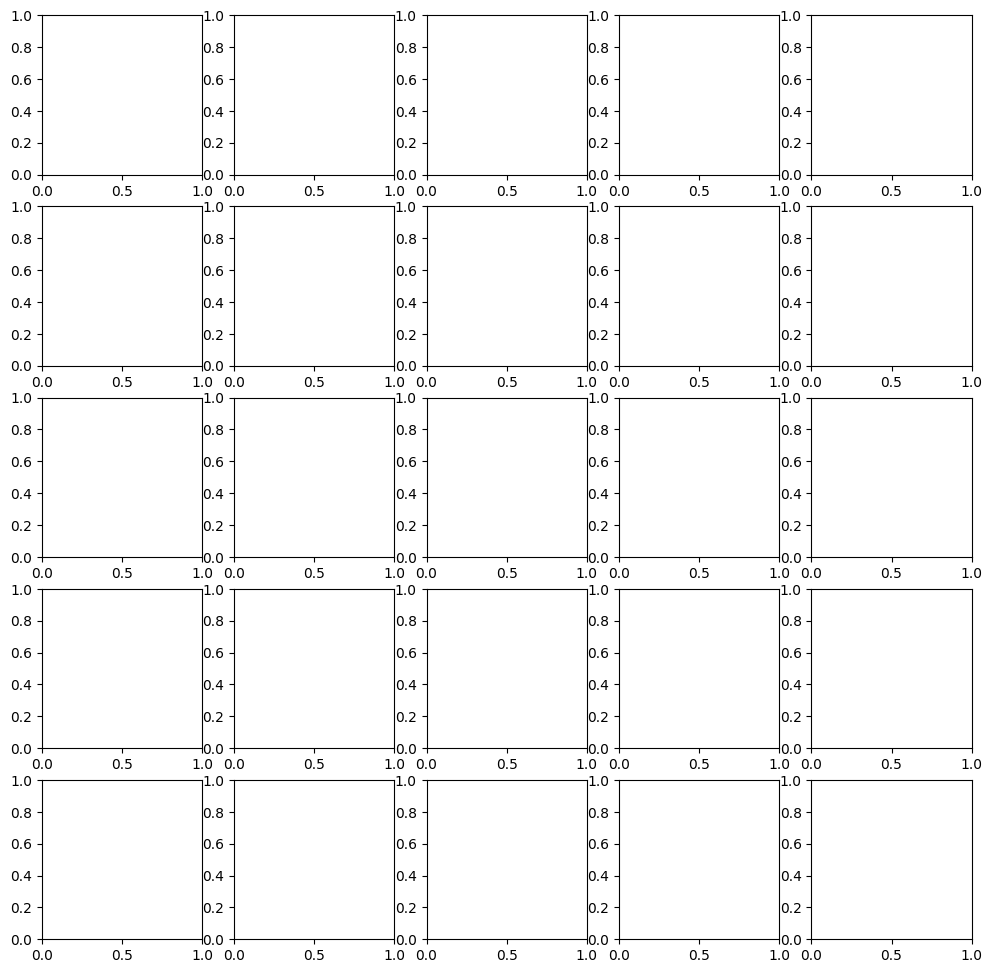

In [42]:
n_flats = 25
fig, ax = plt.subplots(5, 5, figsize=(12, 12))
ax = ax.ravel()

all_flat_names = list(w.flats.keys())
selected_flats = np.random.choice(all_flat_names, size=n_flats, replace=False)

for i, flat_name in enumerate(selected_flats):

    viewer.draw_flat(flat_name, ax=ax[i])
    ax[i].set_title(flat_name)
    ax[i].axis('off')

fig.suptitle('Randomly selected flats')
fig.tight_layout(pad=1.2)

In [47]:
w.maps['E3M6']['metadata']

{'map_lims': (np.int64(-2496), np.int64(632), np.int64(-1432), np.int64(1720)),
 'map_size': (np.int64(3128), np.int64(3152)),
 'map_name': 'E3M6'}

2025-03-28 17:43:03.948 | INFO     | WADViewer:draw_map:88 - Plotted map E3M6.


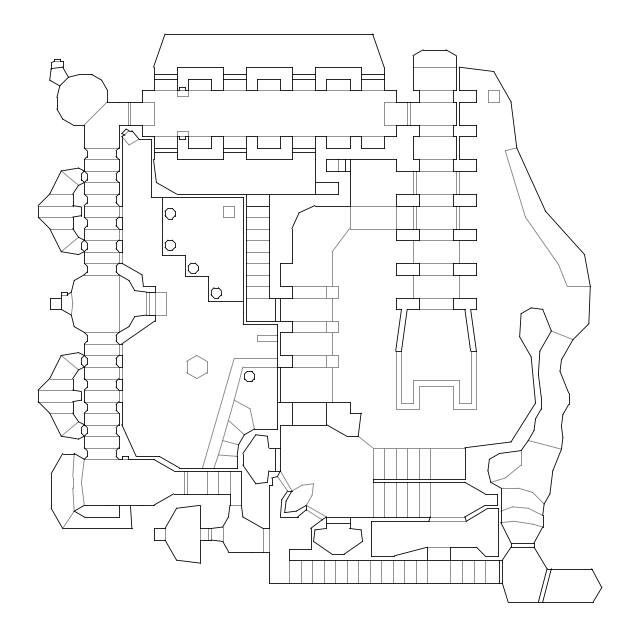

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
viewer.draw_map('E3M6', palette='OMGIFOL', ax=ax)

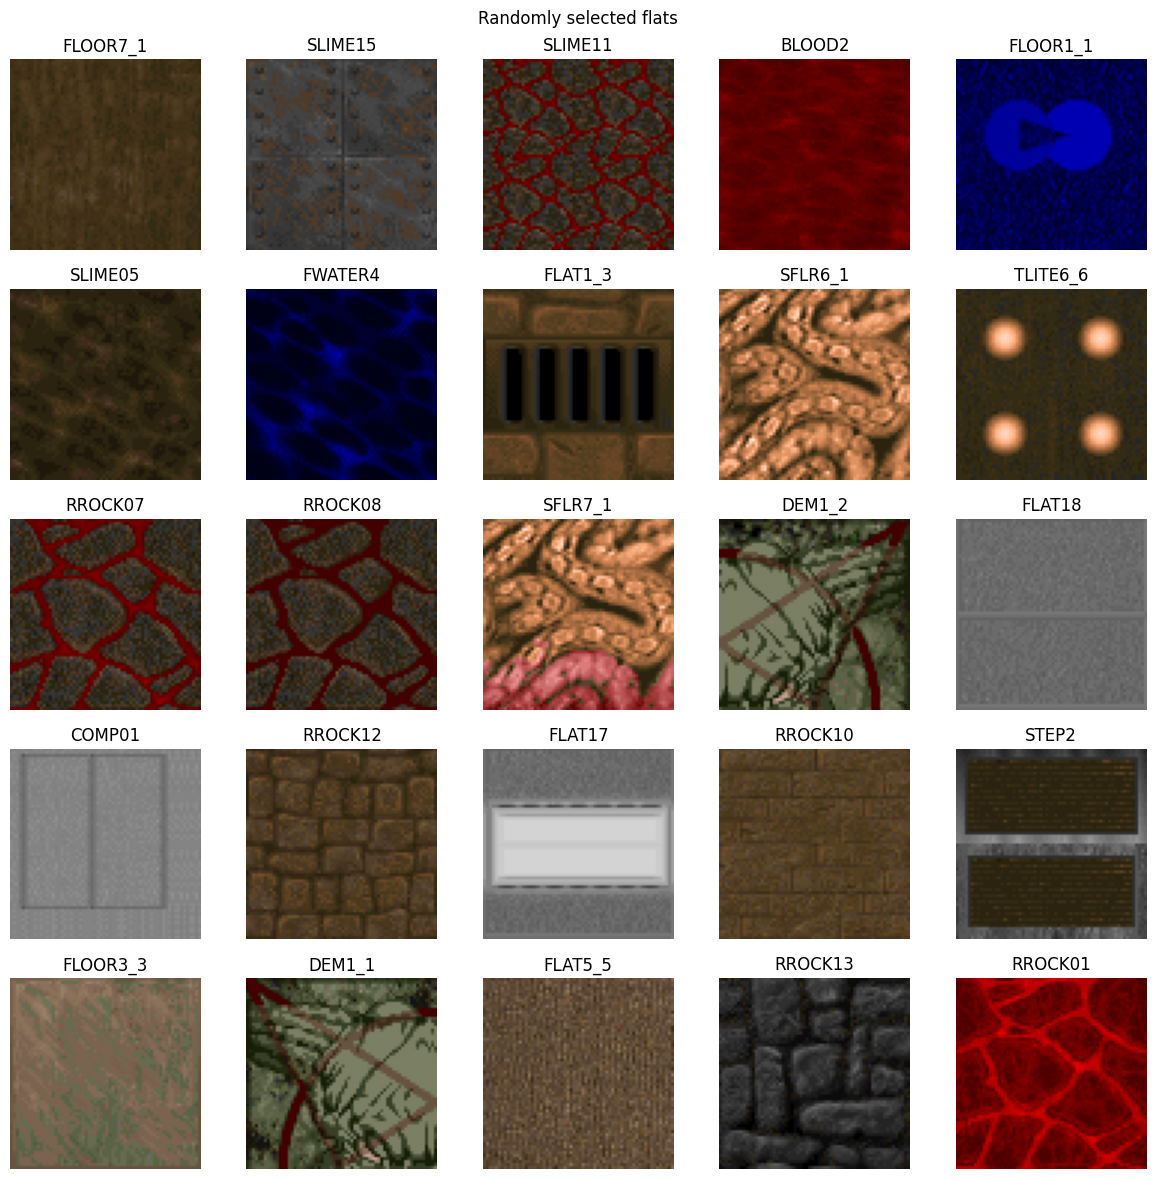

In [5]:
n_flats = 25
fig, ax = plt.subplots(5, 5, figsize=(12, 12))
ax = ax.ravel()

all_flat_names = list(w.flats.keys())
selected_flats = np.random.choice(all_flat_names, size=n_flats, replace=False)

for i, flat_name in enumerate(selected_flats):

    rgb_image = w.draw_flat(*w.flats[flat_name])

    ax[i].imshow(rgb_image / 255, aspect='equal')
    ax[i].set_title(flat_name)
    ax[i].axis('off')

fig.suptitle('Randomly selected flats')
fig.tight_layout(pad=1.2)

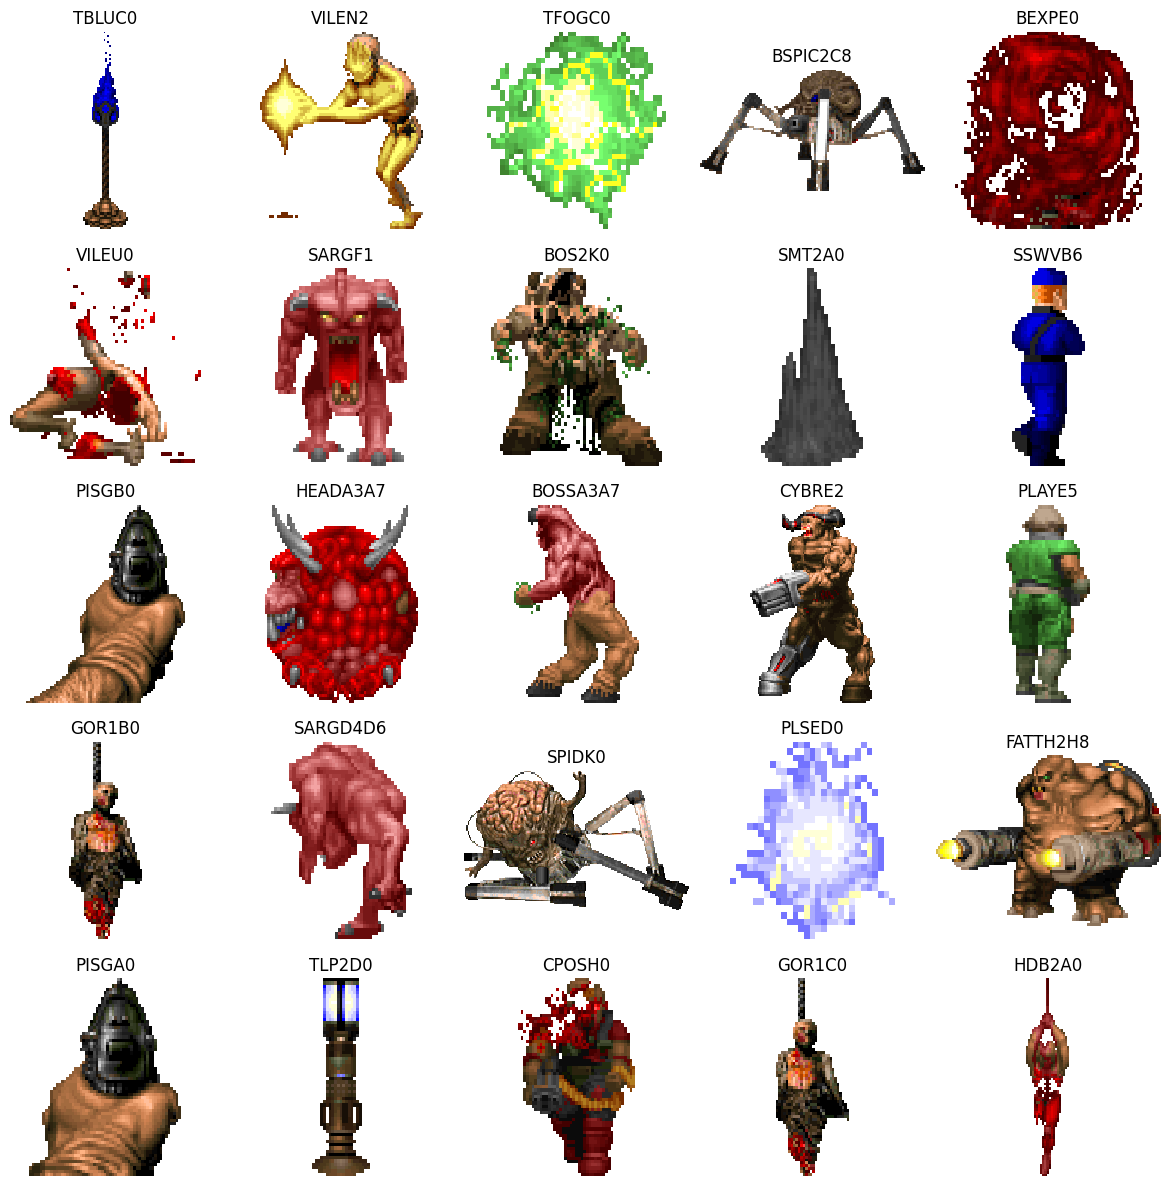

In [6]:
n_sprites = 25
fig, ax = plt.subplots(5, 5, figsize=(12, 12))
ax = ax.ravel()

all_sprite_names = list(w.sprites.keys())
selected_sprites = np.random.choice(all_sprite_names, size=n_sprites, replace=False)

for i, sprite_name in enumerate(selected_sprites):

    rgb_image = w.draw_patch(*w.sprites[sprite_name])

    # Original DOOM had non-square pixels!
    ax[i].imshow(rgb_image / 255, aspect=1.2, interpolation='nearest') 
    ax[i].set_title(sprite_name)
    ax[i].axis('off')

fig.tight_layout(pad=1.2)

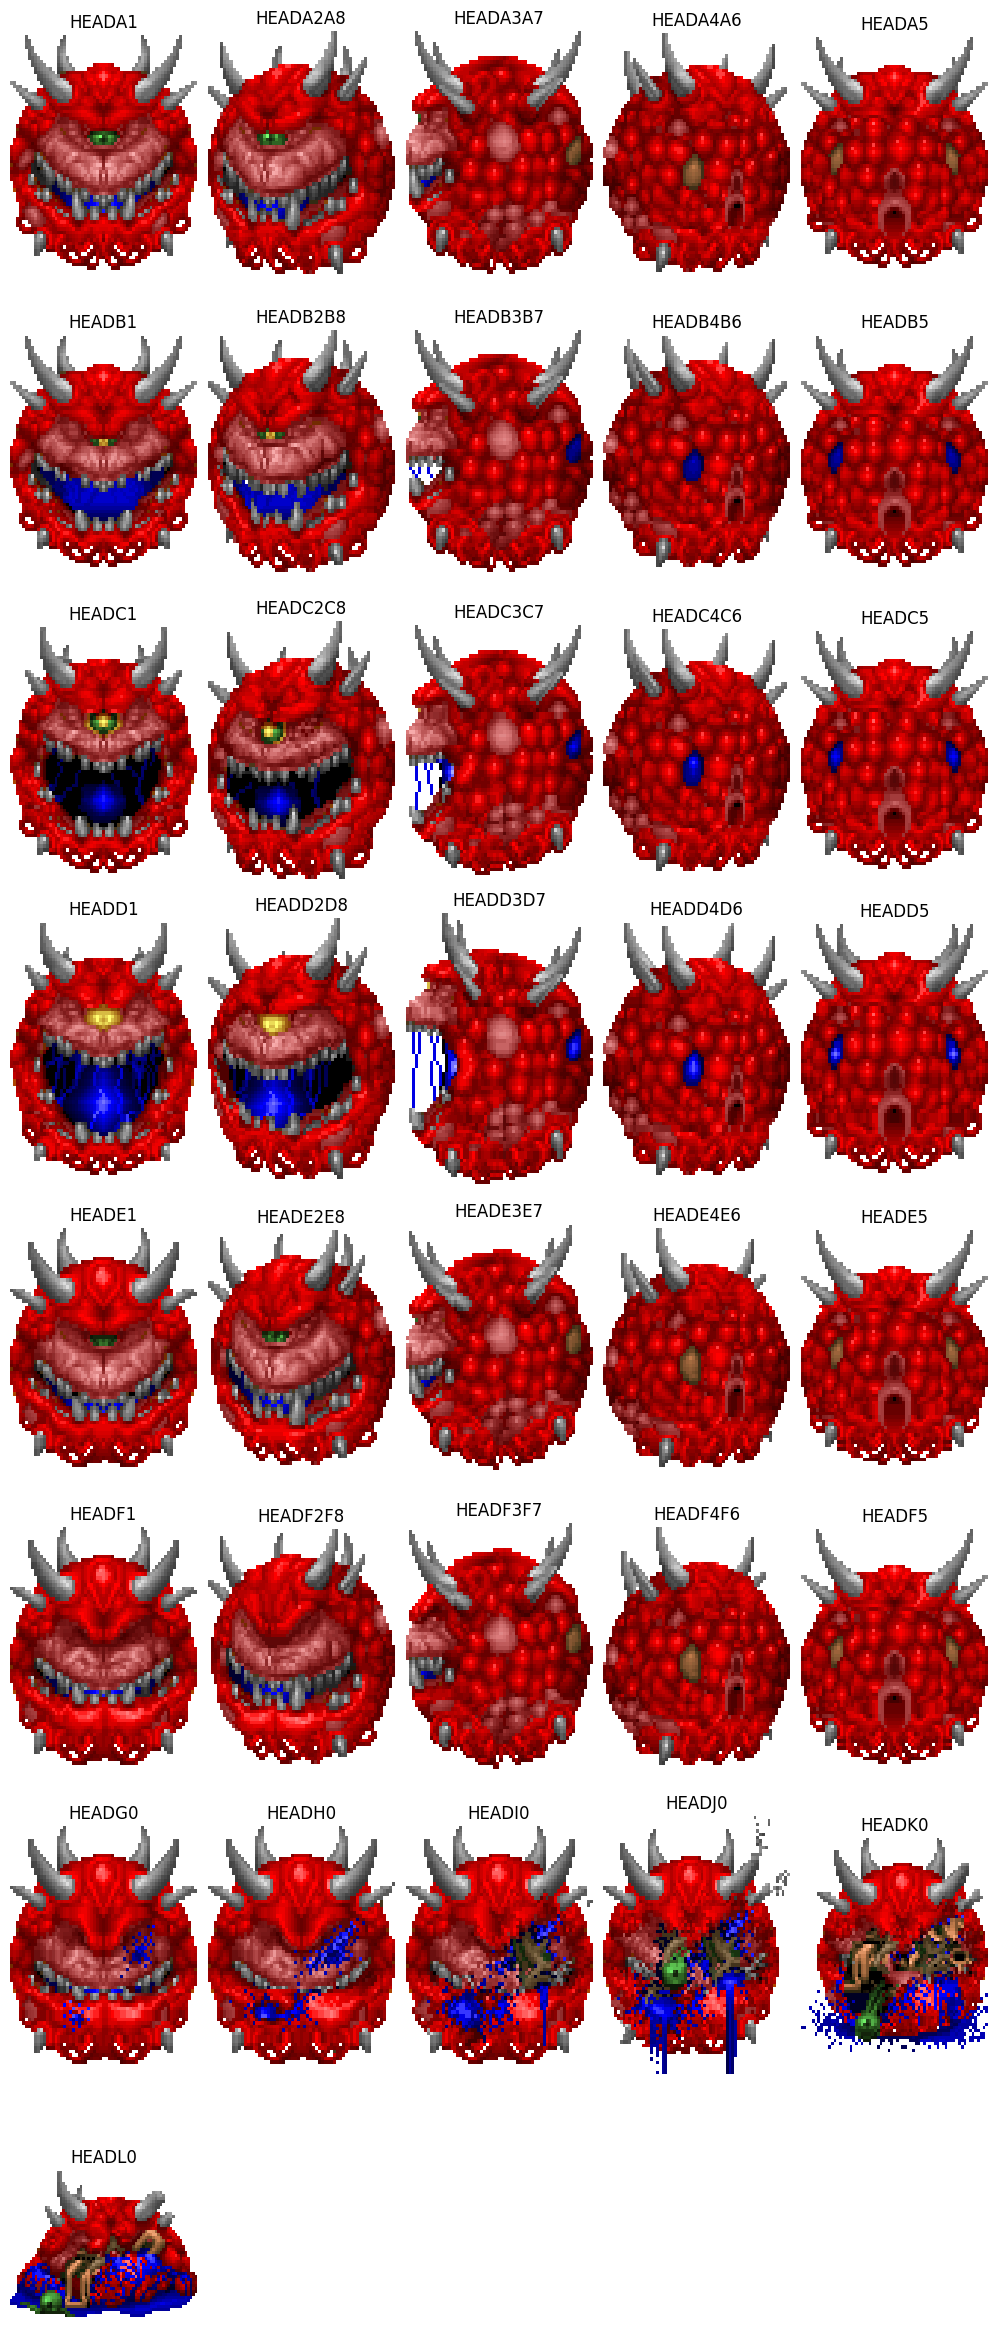

In [7]:
sprite_name = 'HEAD'

sprite_list = w.spritesheets[sprite_name]
ncols=5
nrows = int(np.ceil(len(sprite_list) / ncols))

fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10, 3*nrows))
ax = ax.ravel()

for i, (name, offset, size) in enumerate(sprite_list):
    
    rgb_image = w.draw_patch(offset, size)
    ax[i].imshow(rgb_image / 255, aspect=1.2, interpolation='nearest')
    ax[i].set_title(name)
    ax[i].axis('off')

[ax[i].set_visible(False) for i in range(len(sprite_list), len(ax))]
fig.tight_layout(pad=0.8)